In [1]:
%matplotlib notebook
from utils.dataloader import PascalVOCDataset
from utils.dataloader import myimshow
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td
import torchvision as tv
import numpy as np
from matplotlib import pyplot as plt
from utils.PositionSensitiveScoreMap import PositionSensitiveScoreMap

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [2]:
dataset_root_dir = "/datasets/ee285f-public/PascalVOC2012/"

#Creating training and validation sets. Go to utils/dataloader.py for info on important PascalVOCDataset arguments & attributes
train_set = PascalVOCDataset(dataset_root_dir, mode= 'train')
val_set = PascalVOCDataset(dataset_root_dir, mode= 'val')

#Create dataloaders
B = 50
train_loader = td.DataLoader(train_set, batch_size = B, pin_memory = True, shuffle = True)
val_loader = td.DataLoader(val_set, batch_size = B, pin_memory = True)

<IPython.core.display.Javascript object>


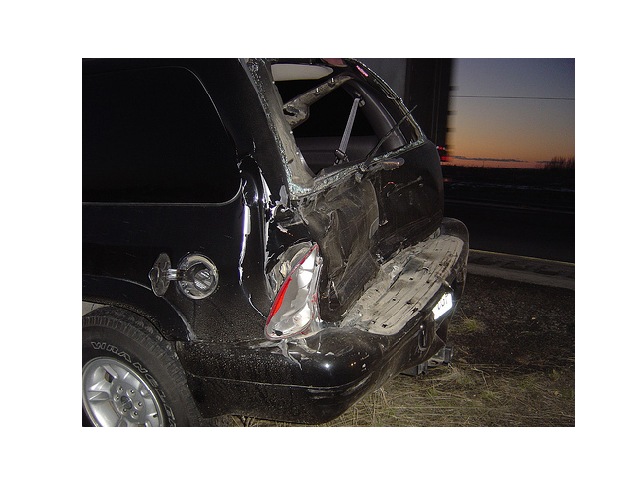

Bounding box corners tensor([[  1,   1, 375, 395]])


In [3]:
#Training set image demo
fig, ax = plt.subplots()
x, bbox, a = train_set.__getitem__(15)
h = myimshow(x, ax)

print("Bounding box corners", bbox)

In [4]:
tensor_im = x.to(device).unsqueeze(0)

torch.Size([3, 375, 500])

In [9]:
#before running, $cd Multi-Object-Detection/model/utils/nms
#then            $python3 build.py build_ext --inplace

from model.region_proposal_network import RegionProposalNetwork
from model.resnet101extractor import Resnet101Extractor
from model.rfcn_resnet101 import Resnet101RoIHead
from model.rfcn_resnet101 import RFCNResnet101
n_fg_class = 20
feat_stride = 520//17
extractor = Resnet101Extractor().to(device)
rpn = RegionProposalNetwork(in_channels=1024, mid_channels = 1024).to(device)
head = Resnet101RoIHead( #Main class to change
            n_class=n_fg_class + 1,
            roi_size=7,
            spatial_scale=(1. / feat_stride)
        ).to(device)

rfcn = RFCNResnet101().to(device)

/datasets/home/home-02/50/150/prvo/Multi-Object-Detection/model/rfcn_resnet101.py:82: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(self.cls_layer.weight.data, 0.0, 0.01)
/datasets/home/home-02/50/150/prvo/Multi-Object-Detection/model/rfcn_resnet101.py:86: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(self.reg_layer.weight.data, 0.0, 0.01)


In [11]:
out = rfcn(tensor_im)

/datasets/home/home-02/50/150/prvo/Multi-Object-Detection/utils/PositionSensitiveScoreMap.py:65: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  scores = self.softmax(self.AvgPool(pooling_track.float()))


In [13]:
feature_map = extractor()
rpn_locs, rpn_scores, rois, roi_indices, anchor = rpn.forward(feature_map,(520,520))
#print(rois)
#rpn_locs, rpn_scores, rois, roi_indices, anchor = rpn.forward(feature_map,feature_map.shape[2:])
#print(rois)
cls_layer = nn.Conv2d(1024,21*7*7, [1,1], padding=0, stride=1).cuda()
#nn.init.kaiming_normal_(cls_layer.weight.data)

cls_conv_out = cls_layer(feature_map)
PSSM =PositionSensitiveScoreMap()
#print(PSSM)
scores = PSSM(cls_conv_out,rois)
print(rois.shape[0])
print(scores.sum(2))

4